### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

# SOLUTIONS

## Solution 1


1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


In [19]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats


# Load the dataset 
data = np.load('/Users/jarretsm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy') 

# Extract data
x = data[:, 0] #first column is Feature 1
y = data[:, 1] #Second column is Feature 2
labels=data[:,2]


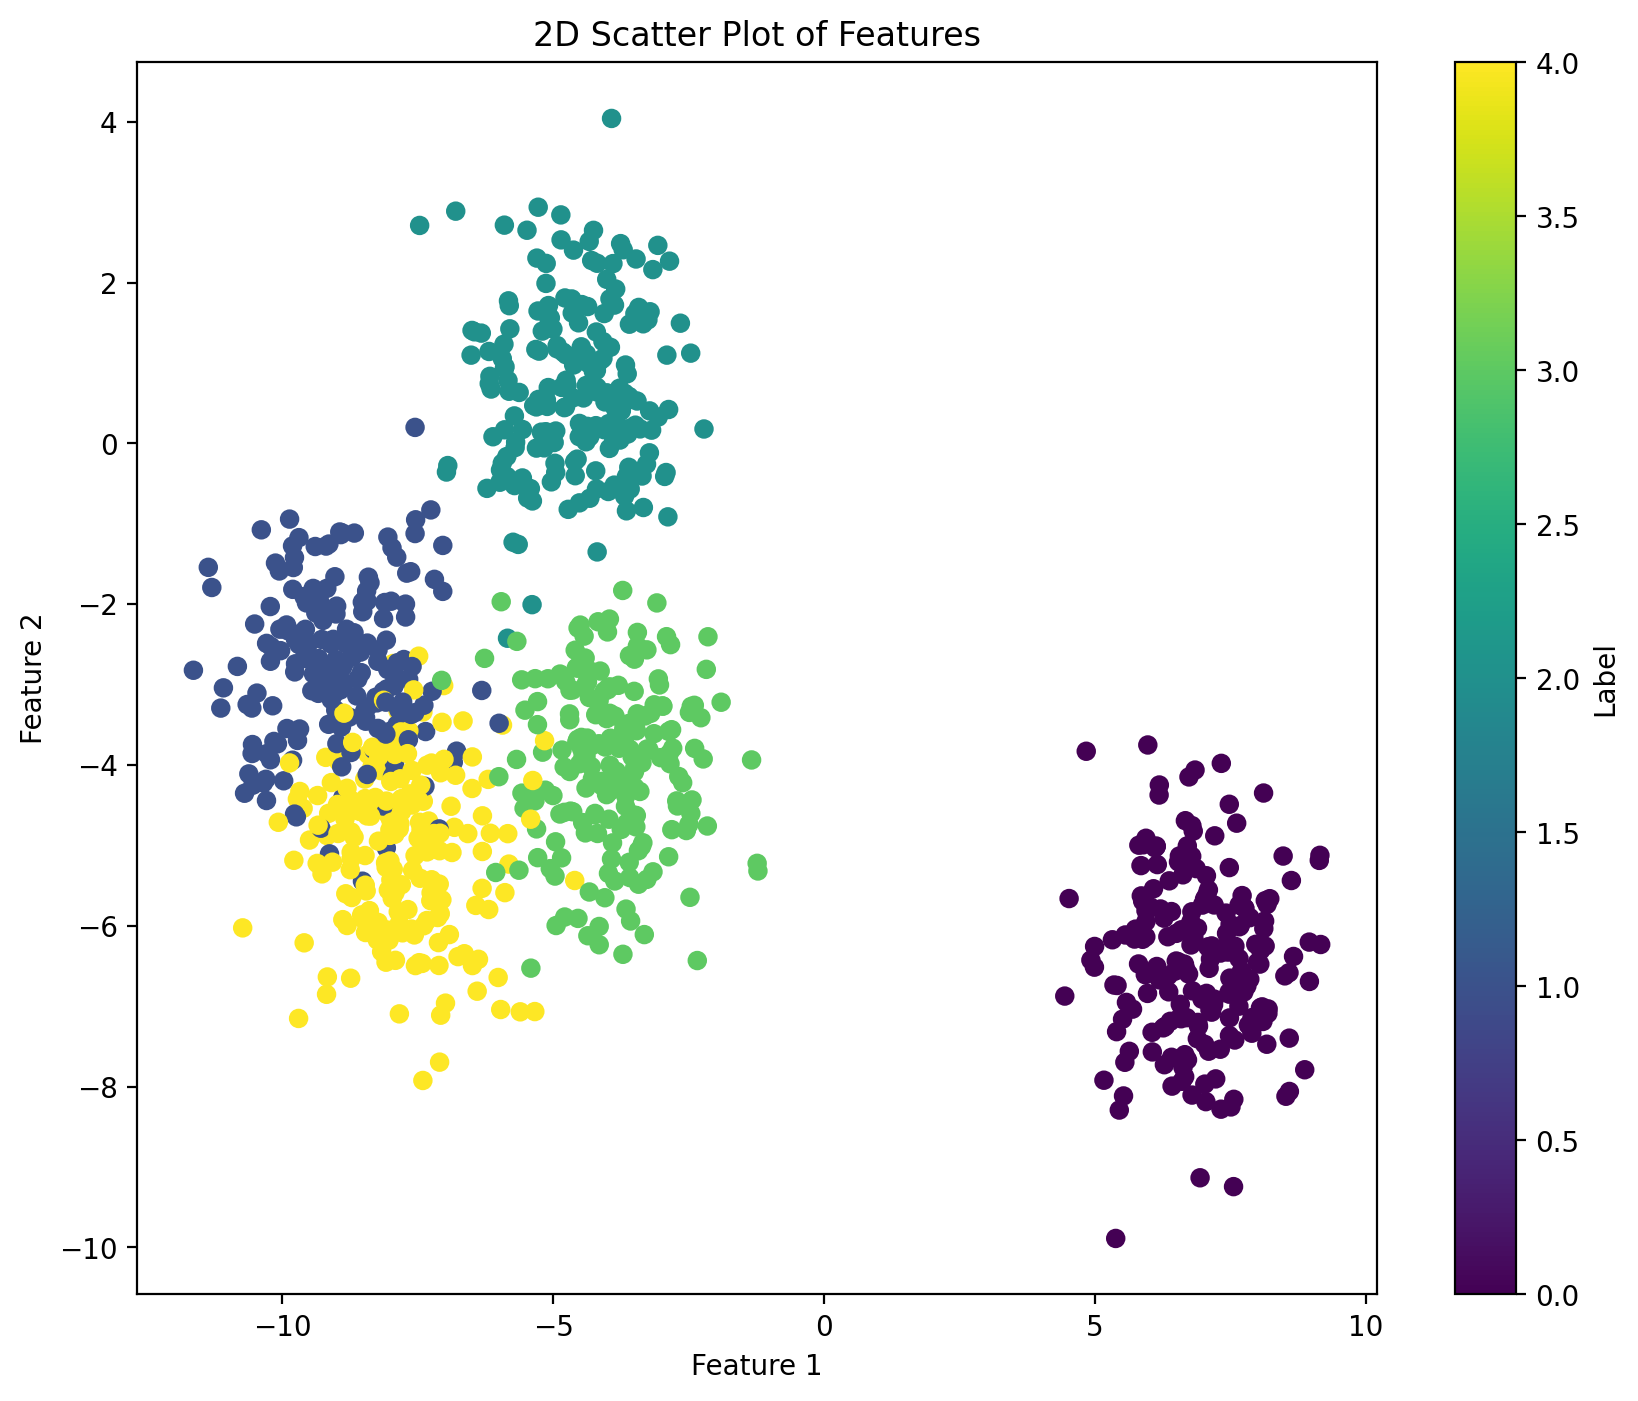

In [20]:
# Plot the data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, y, c=labels)
plt.title('2D Scatter Plot of Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Label')
plt.show()

## Solution 2

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

In [21]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


# Test 30 bandwidths from 0.1 to 1.0
bwrange = np.linspace(0.1, 1.0, 30)  

# Number of folds for cross-validation
K = 5  

# Setup GridSearchCV with KDE
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)  # Try each bandwidth with K-folds

# Fit model
grid.fit(x[:, None])  # Fit the data for KDE

# Find the optimal bandwidth
h_opt = grid.best_params_['bandwidth']  # Extract the best bandwidth
print(h_opt)  # Print the optimal bandwidth

print("The best bandwidth is", .286)

0.28620689655172415
The best bandwidth is 0.286


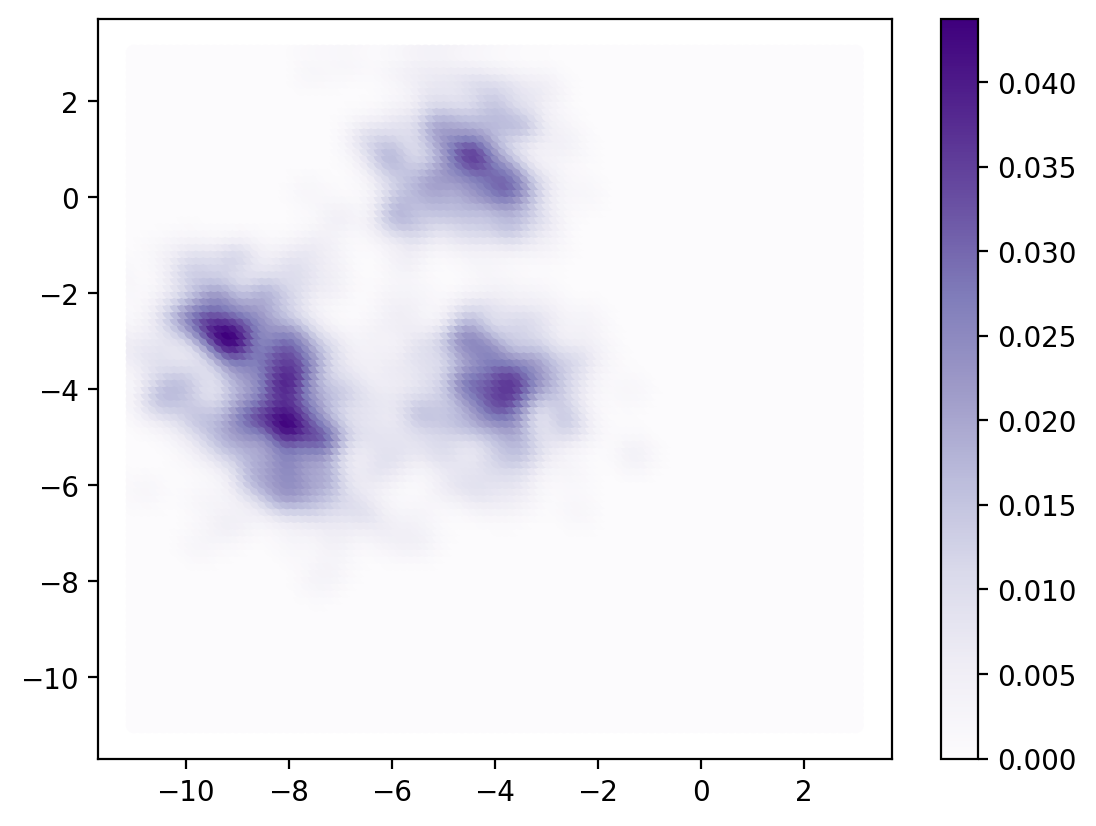

In [22]:
#Do KDE
X = np.vstack([x, y]).T  
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) 

#Set up grid
u = v = np.linspace(-11,3,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) 

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

SRT: Why only fit the bandwidth on feature 1 (i.e., x)? You can do it simultaneously on both features, getting a bandwidth of ~0.47. -2 points.

## Solution 3

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


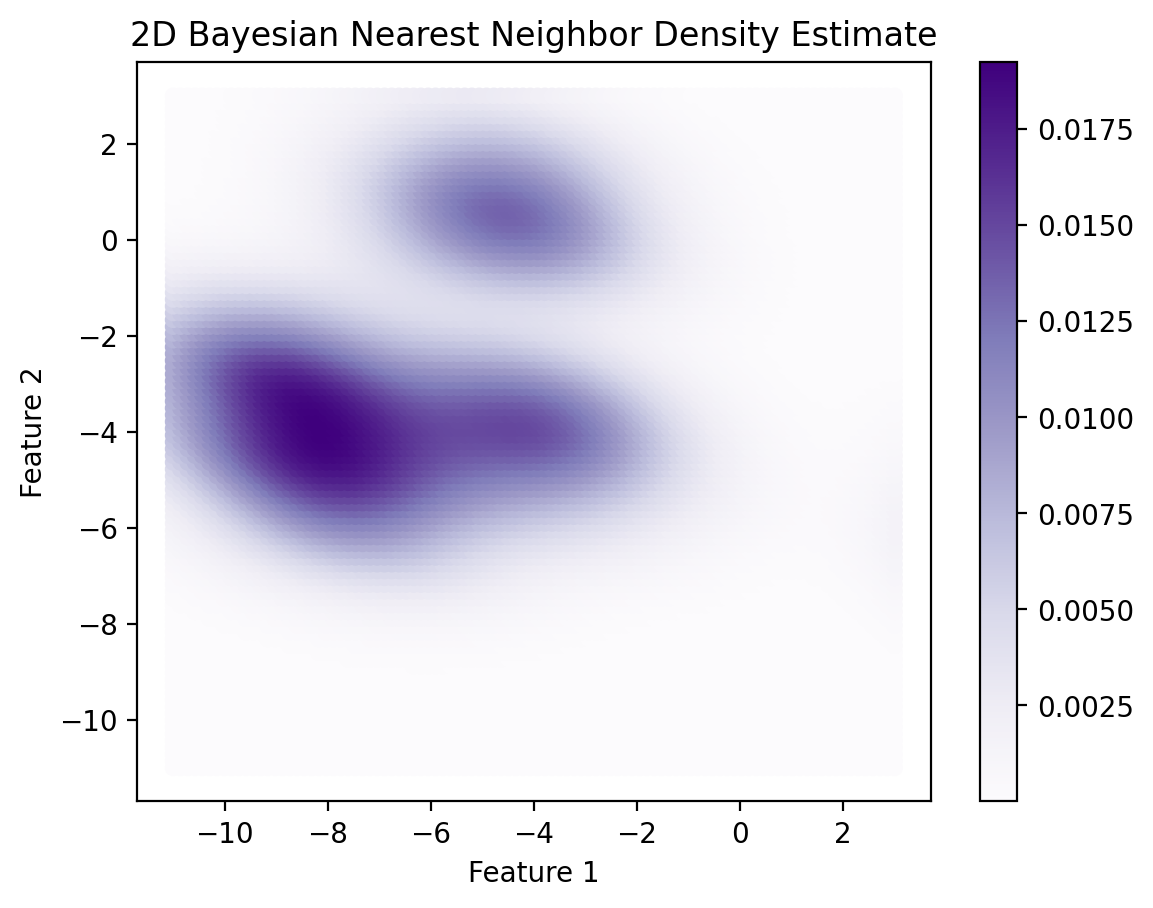

In [23]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde


X = np.vstack([x, y]).T  
k = 5

# Fit the nearest neighbors 
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)

# Compute the density (Bayesian estimate)
radius = distances[:, -1]
density_nbrs = k / (np.pi * radius**2 * X.shape[0]) # finding number within specific area
u = v = np.linspace(-11, 3, 100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

# Run KDE
kde = gaussian_kde(X.T, bw_method=h_opt)
dens_kde = kde(Xgrid.T)

# Plot
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=dens_kde, cmap="Purples", edgecolor="None")
plt.colorbar()  # Show color scale
plt.title('2D Bayesian Nearest Neighbor Density Estimate')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


/var/folders/5c/kkcpl36x6c78d36n8pktxwjm0000gr/T/ipykernel_39889/3685534825.py:6: RuntimeWarning: divide by zero encountered in divide
  density_nbrs = k / (np.pi * radius**2 * X.shape[0])


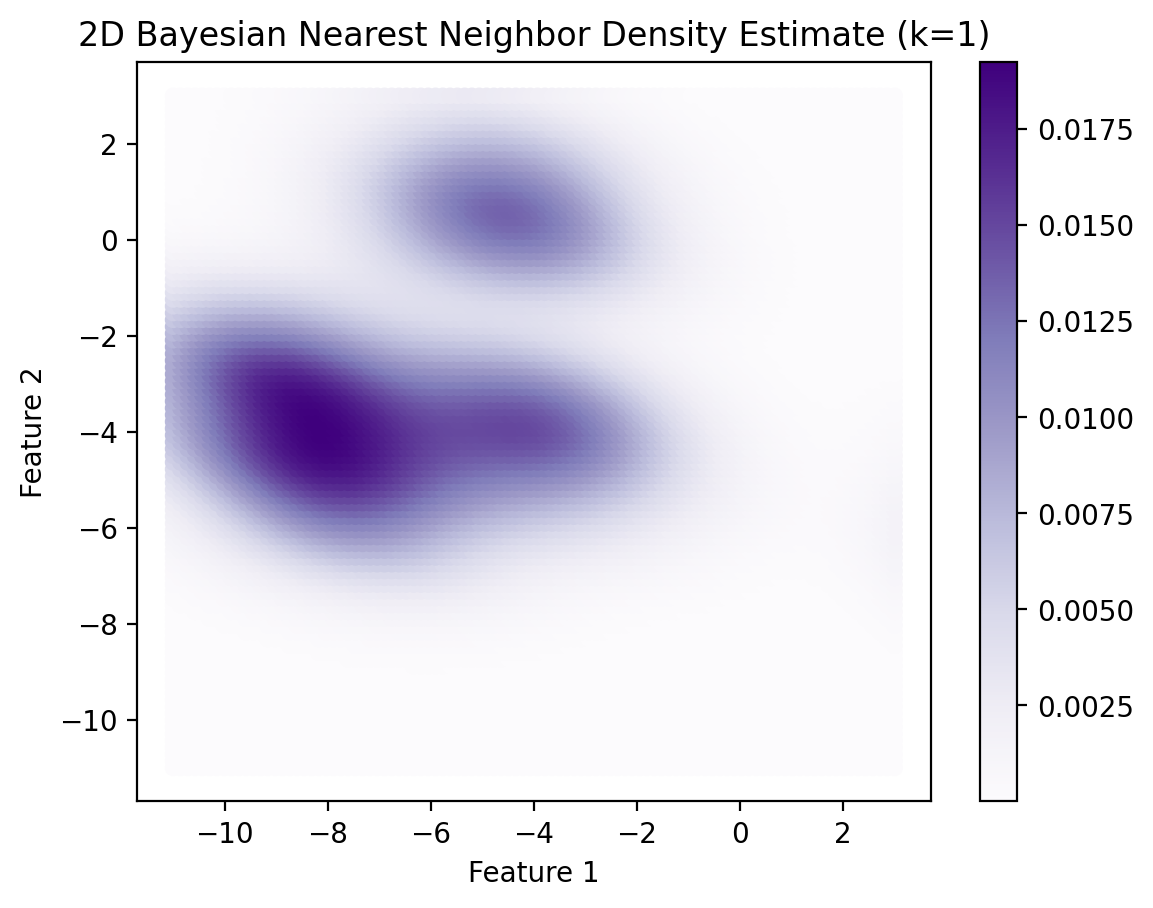

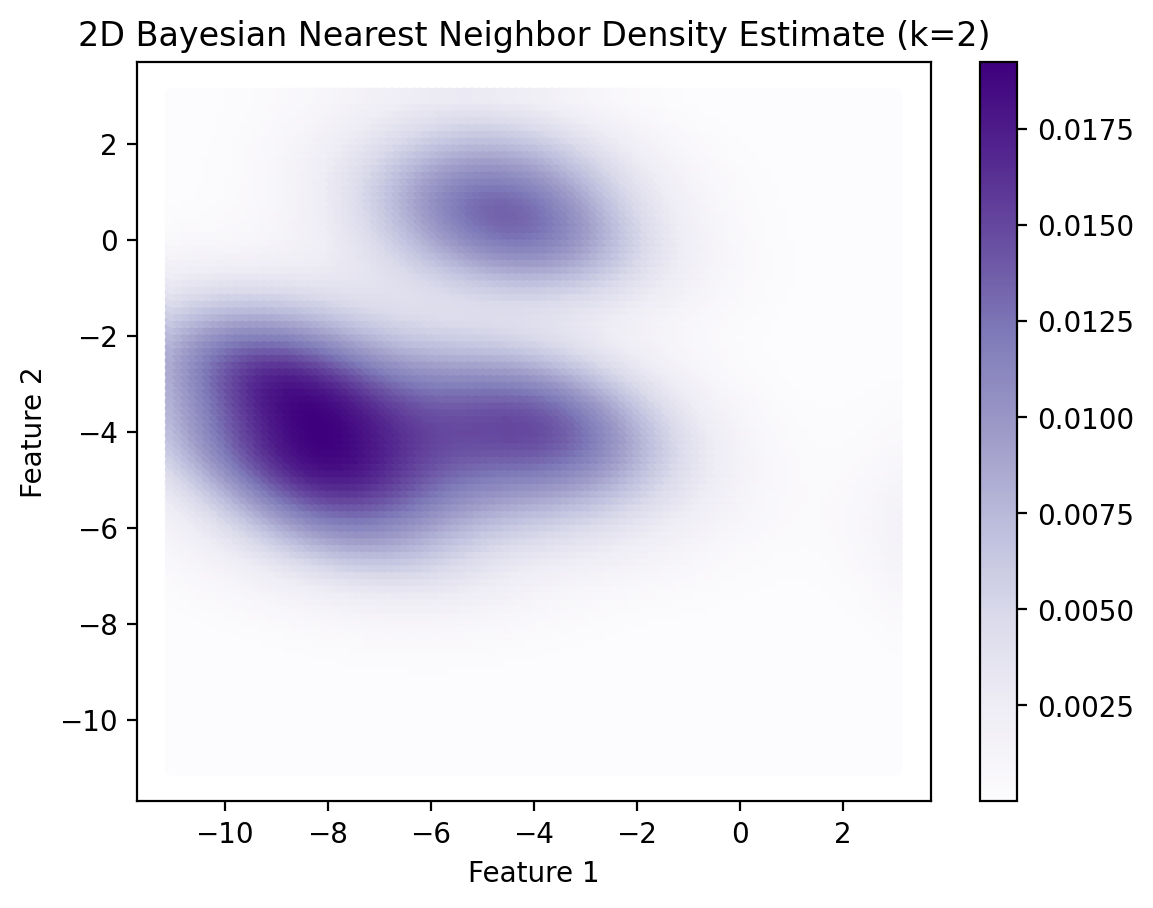

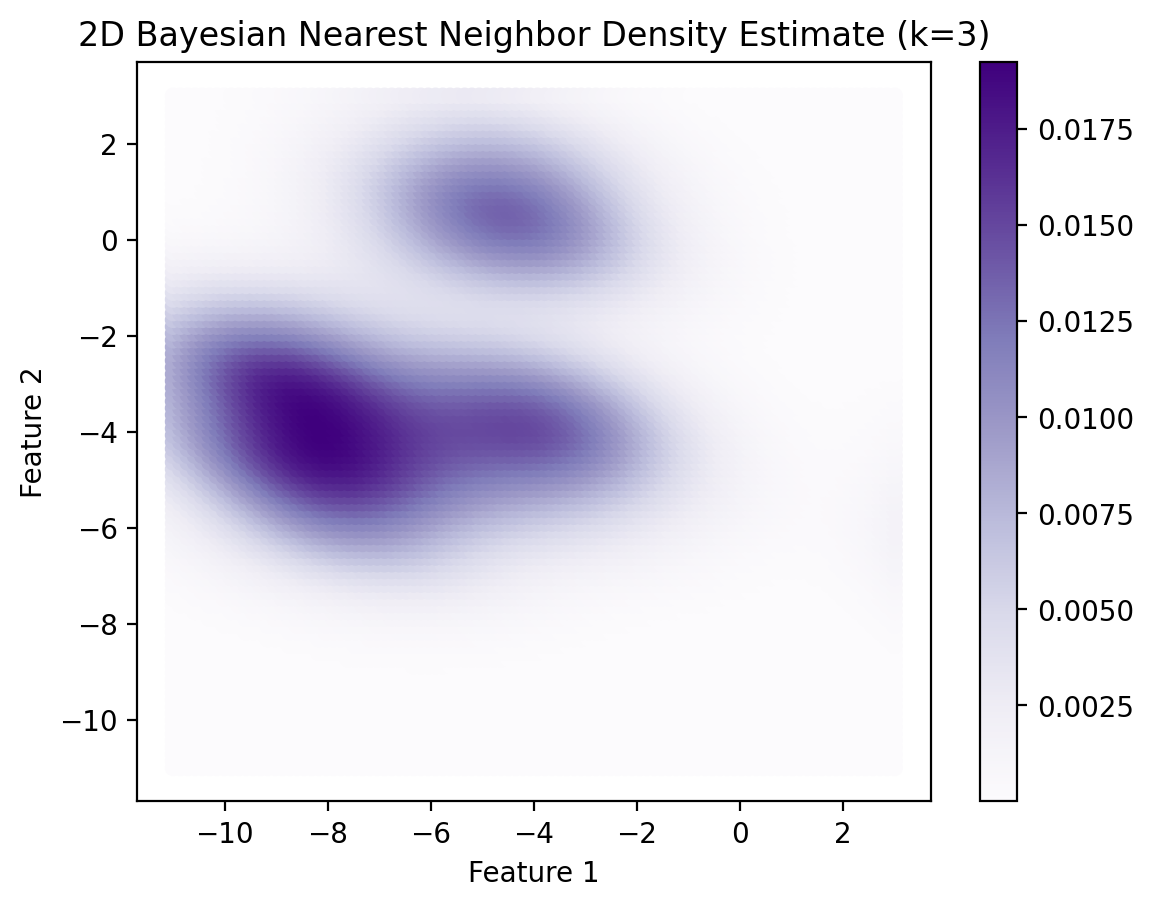

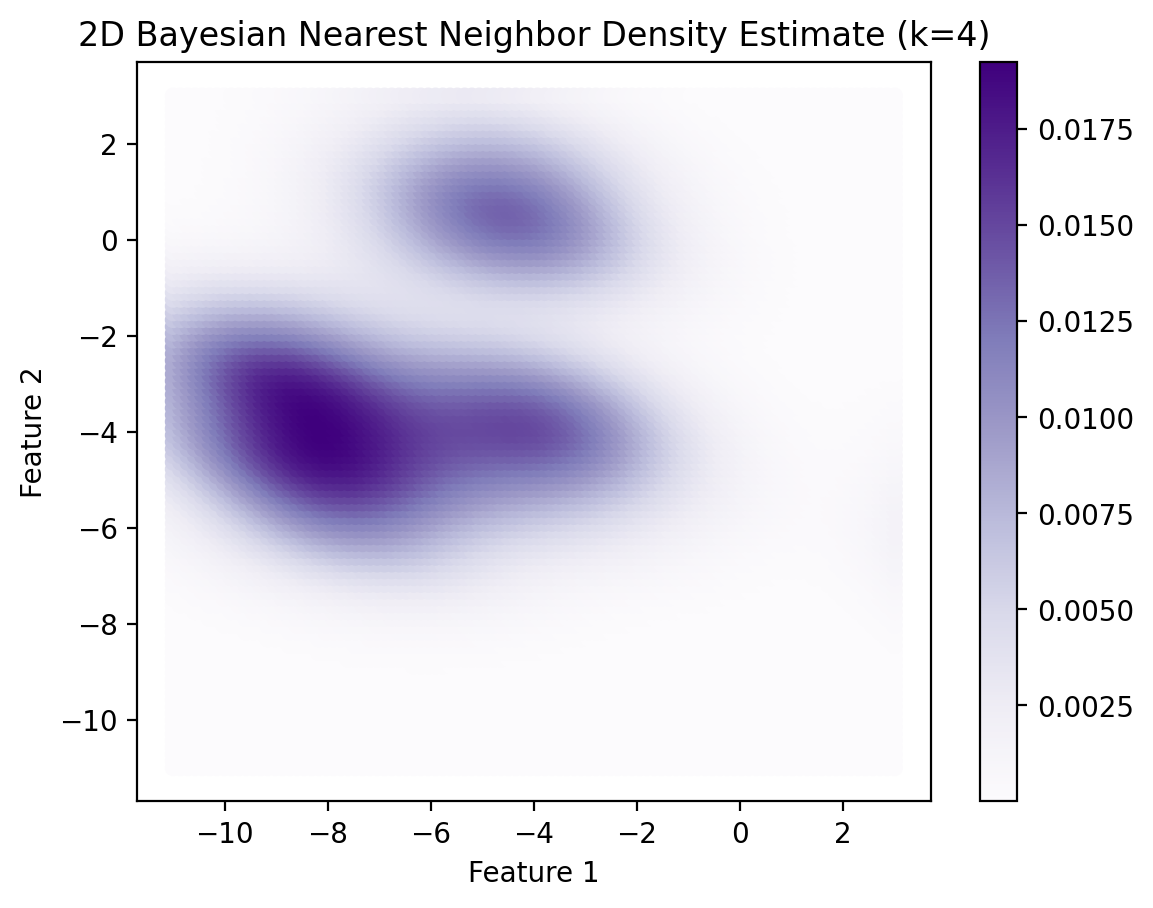

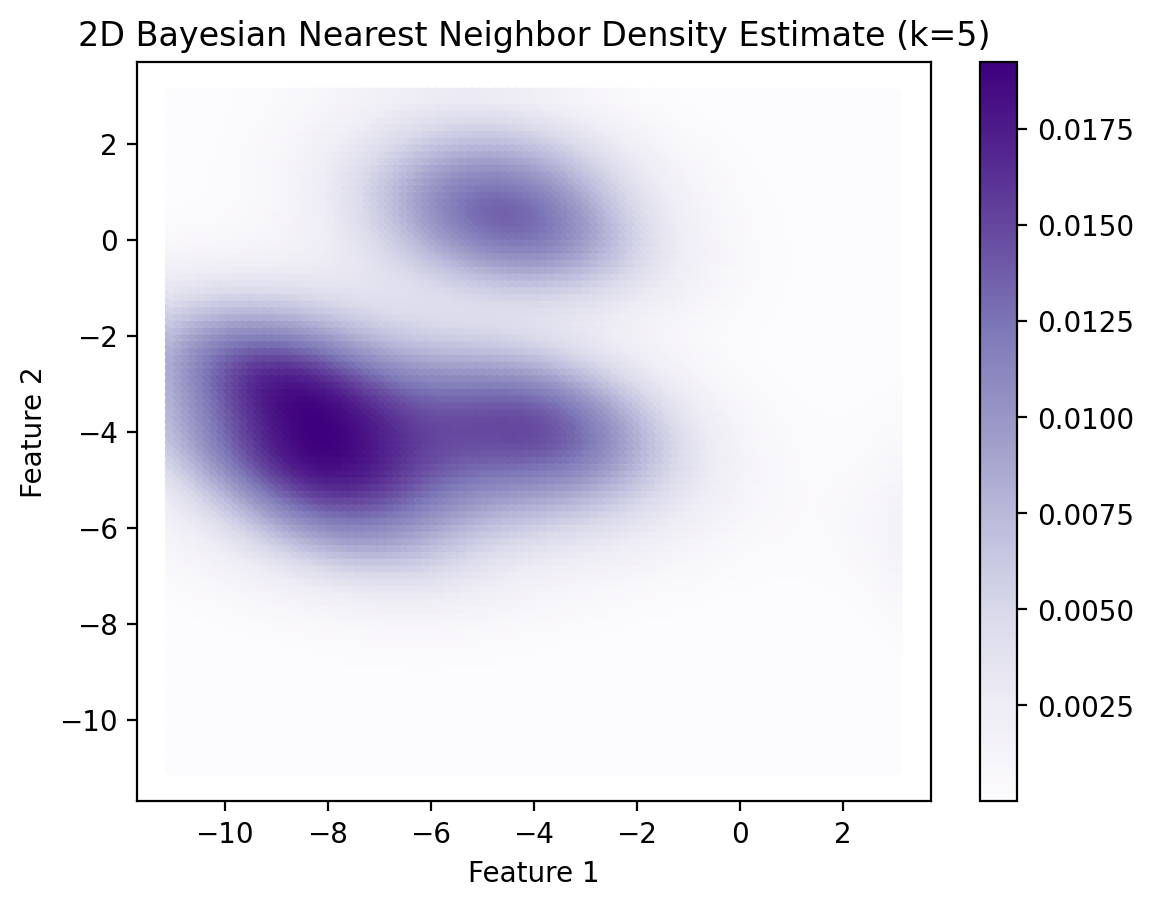

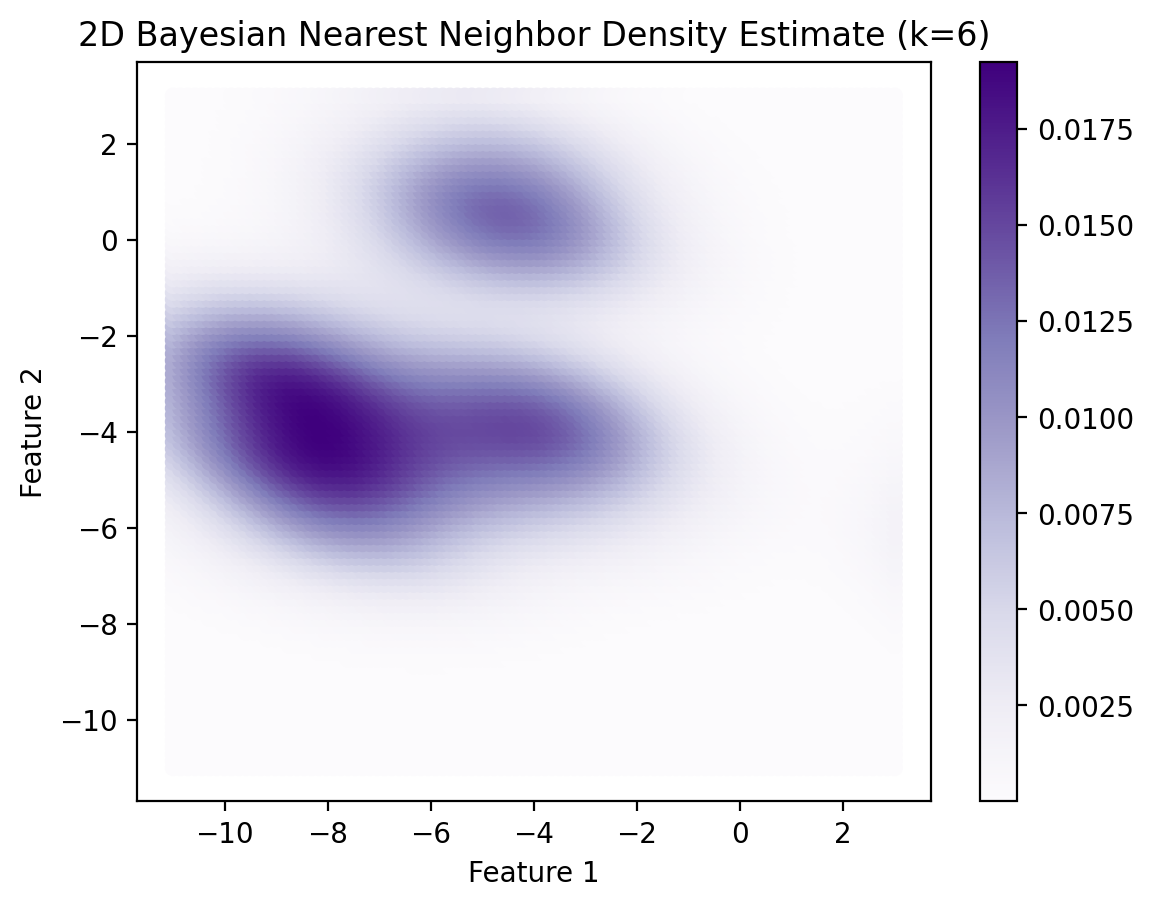

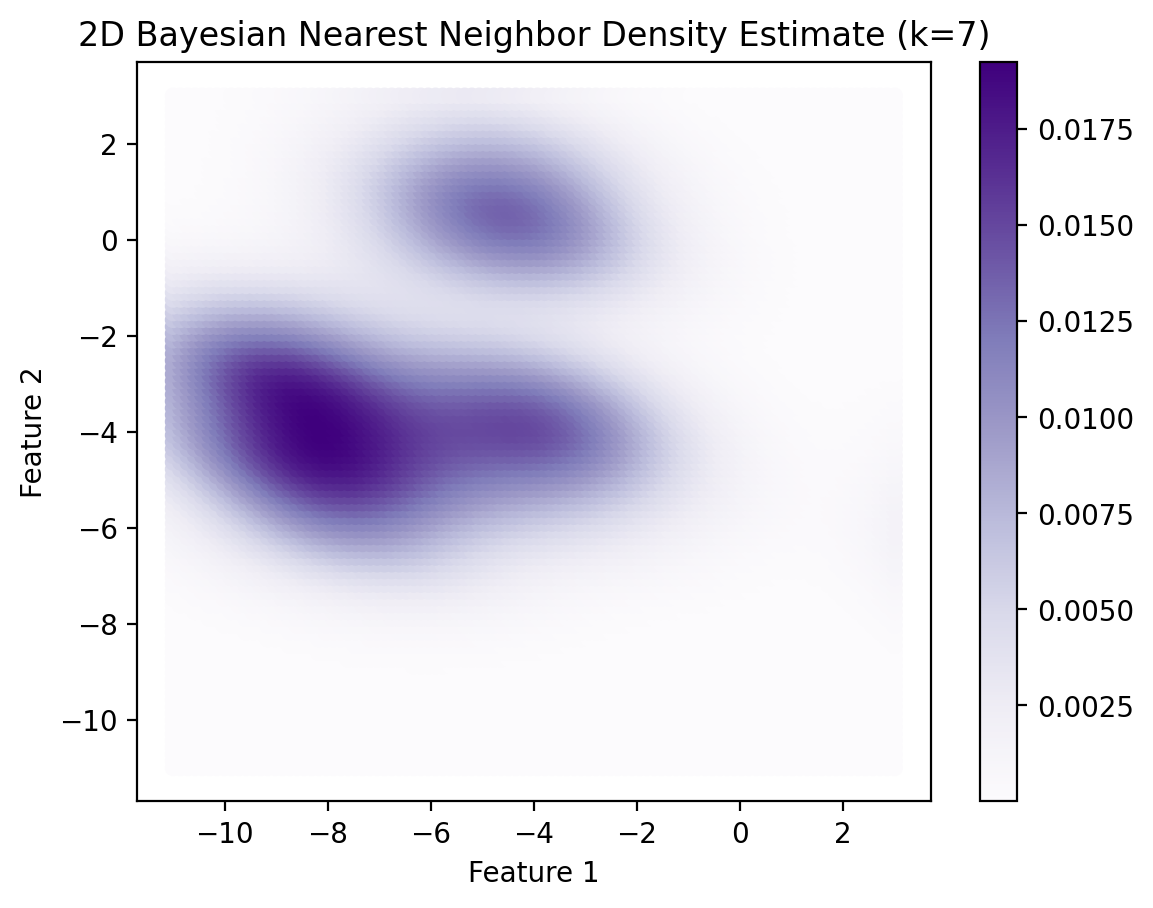

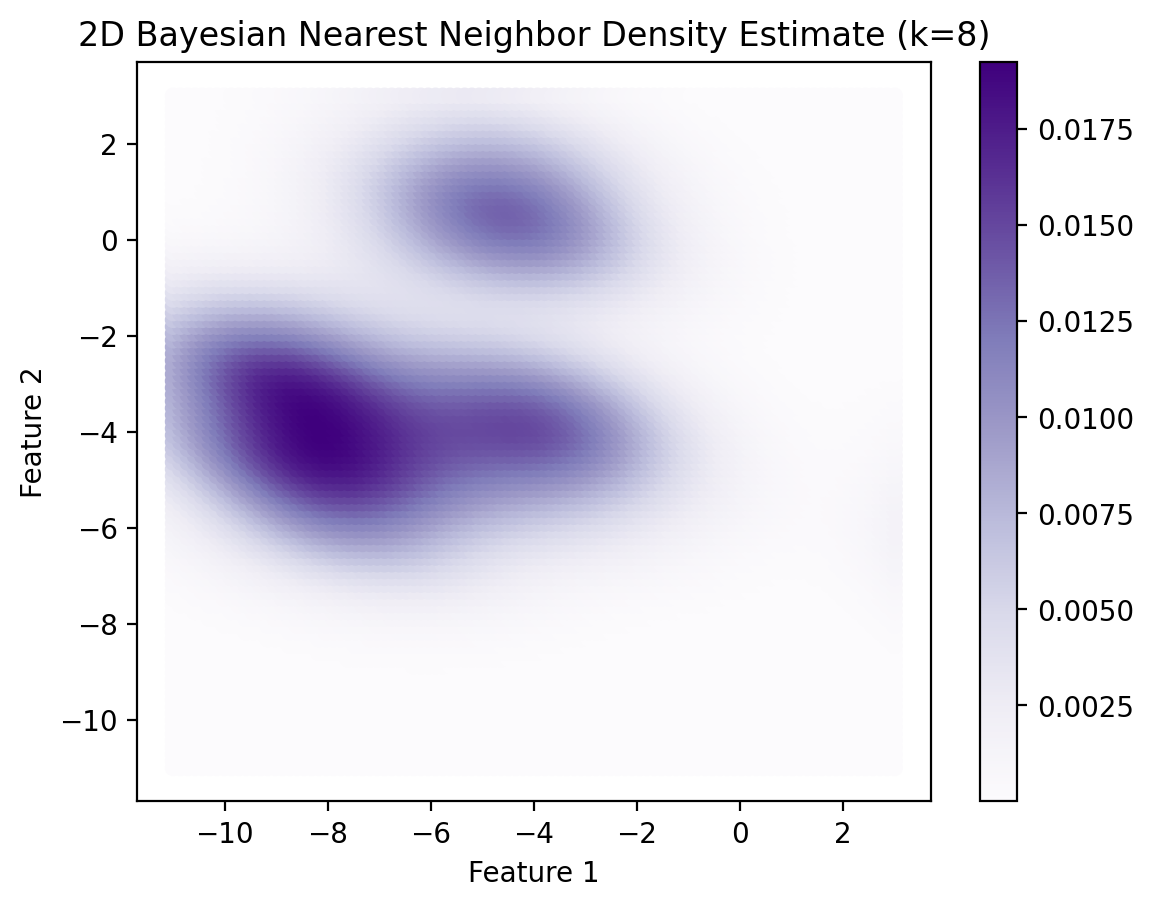

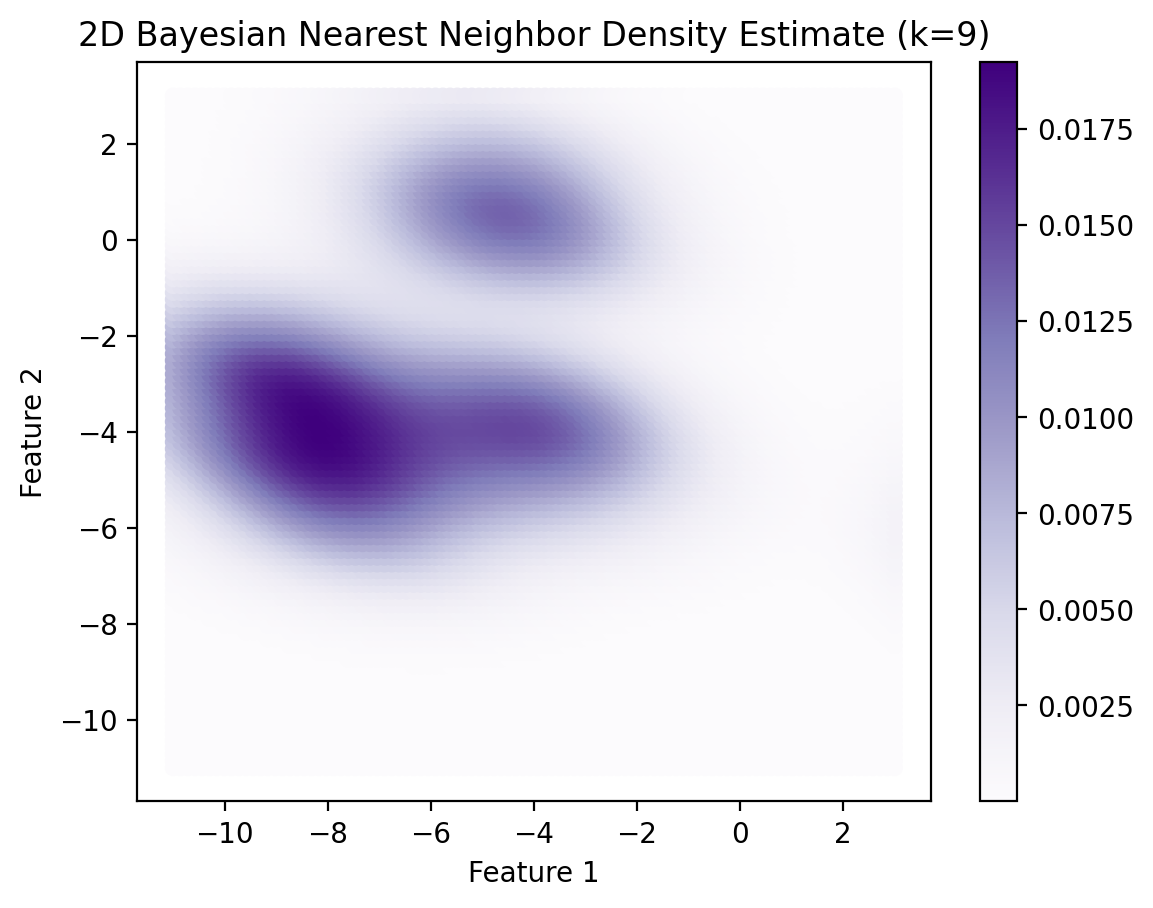

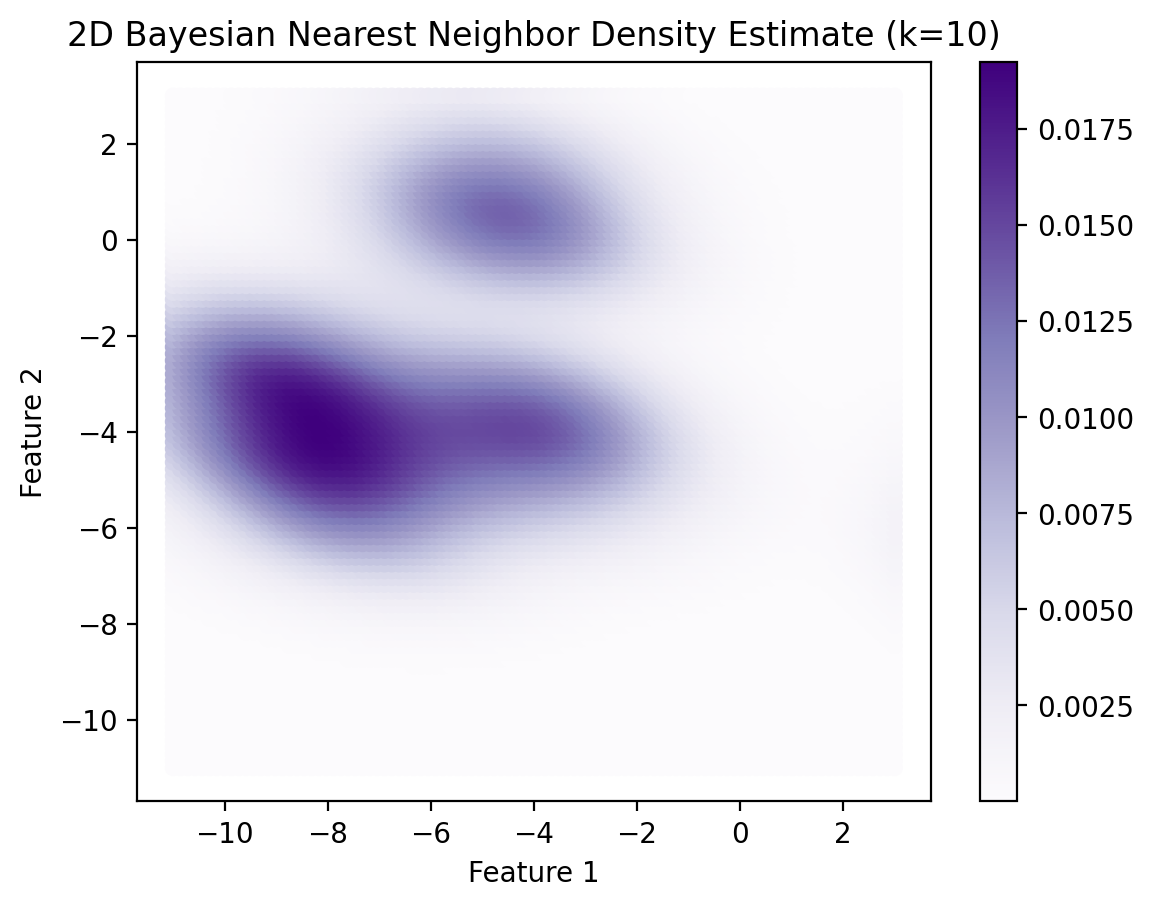

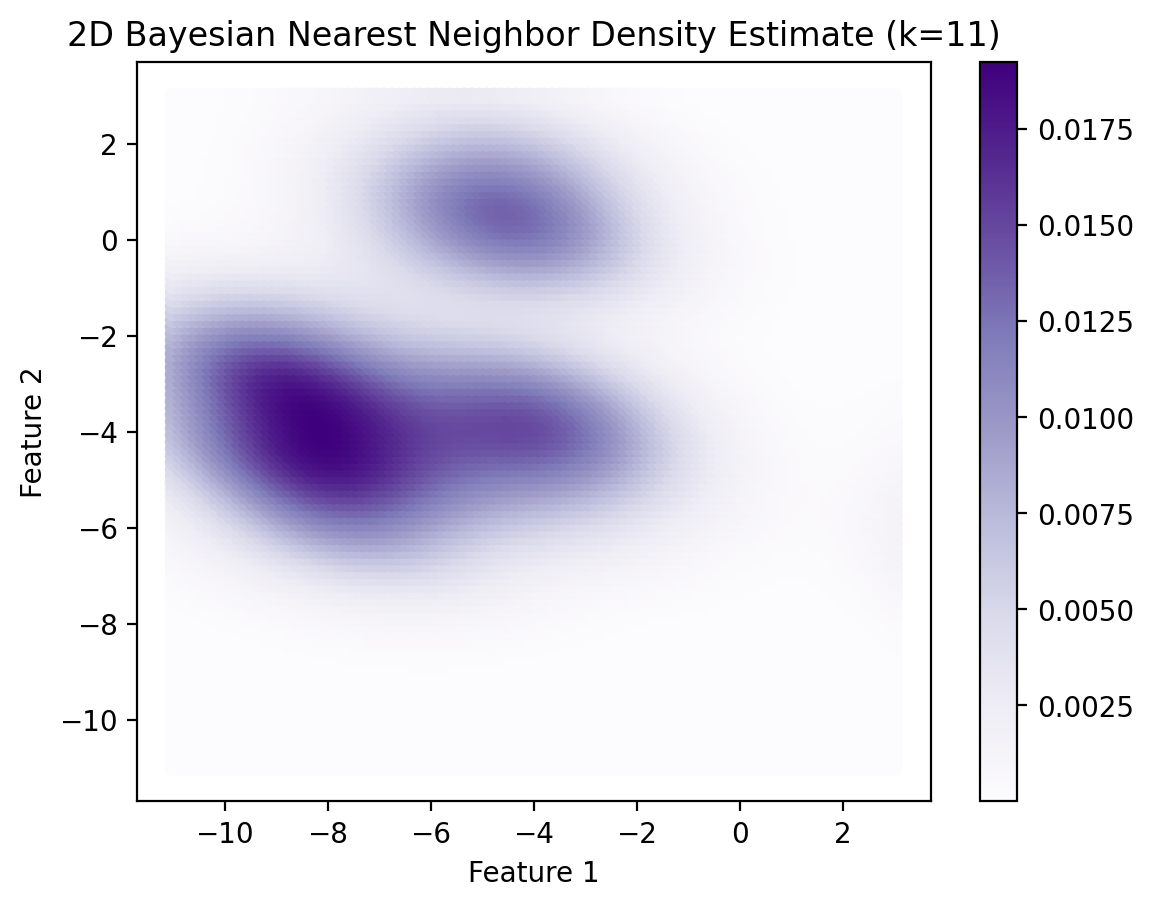

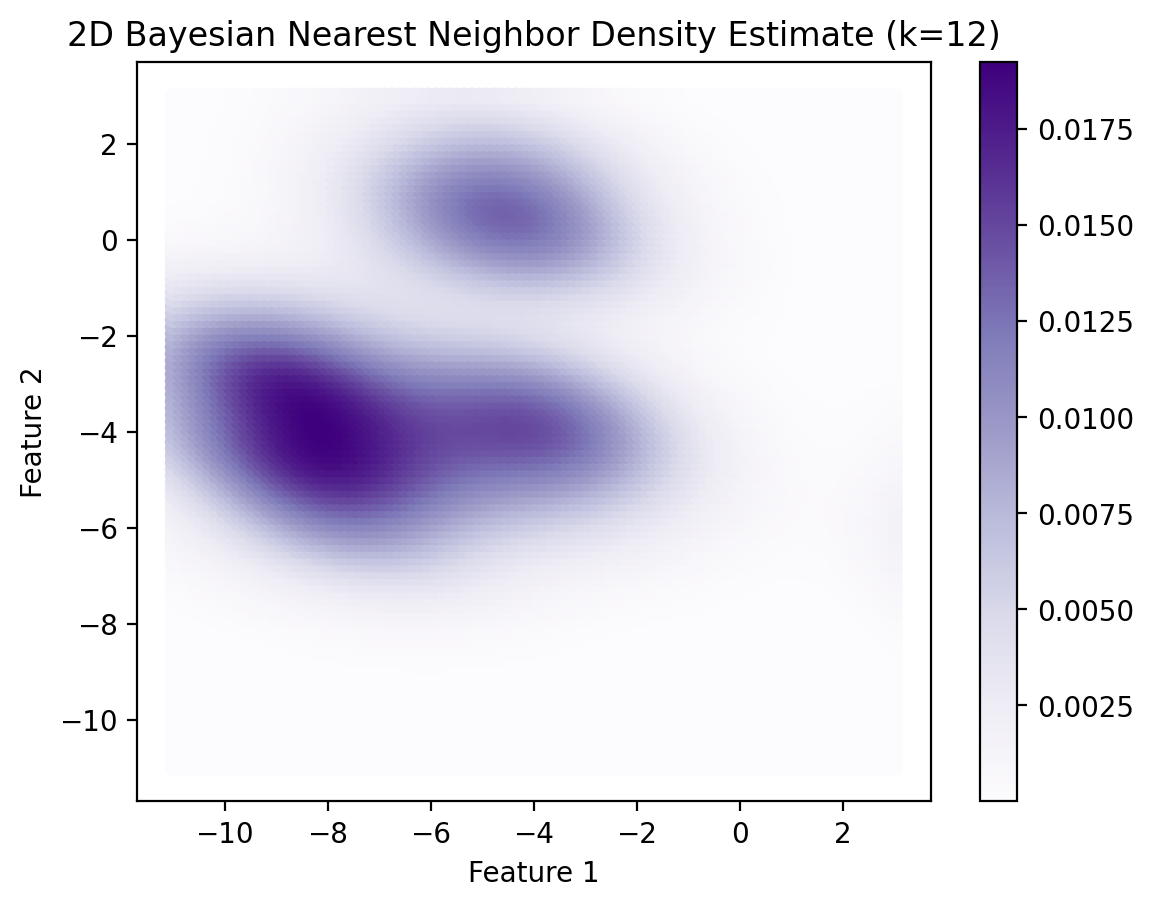

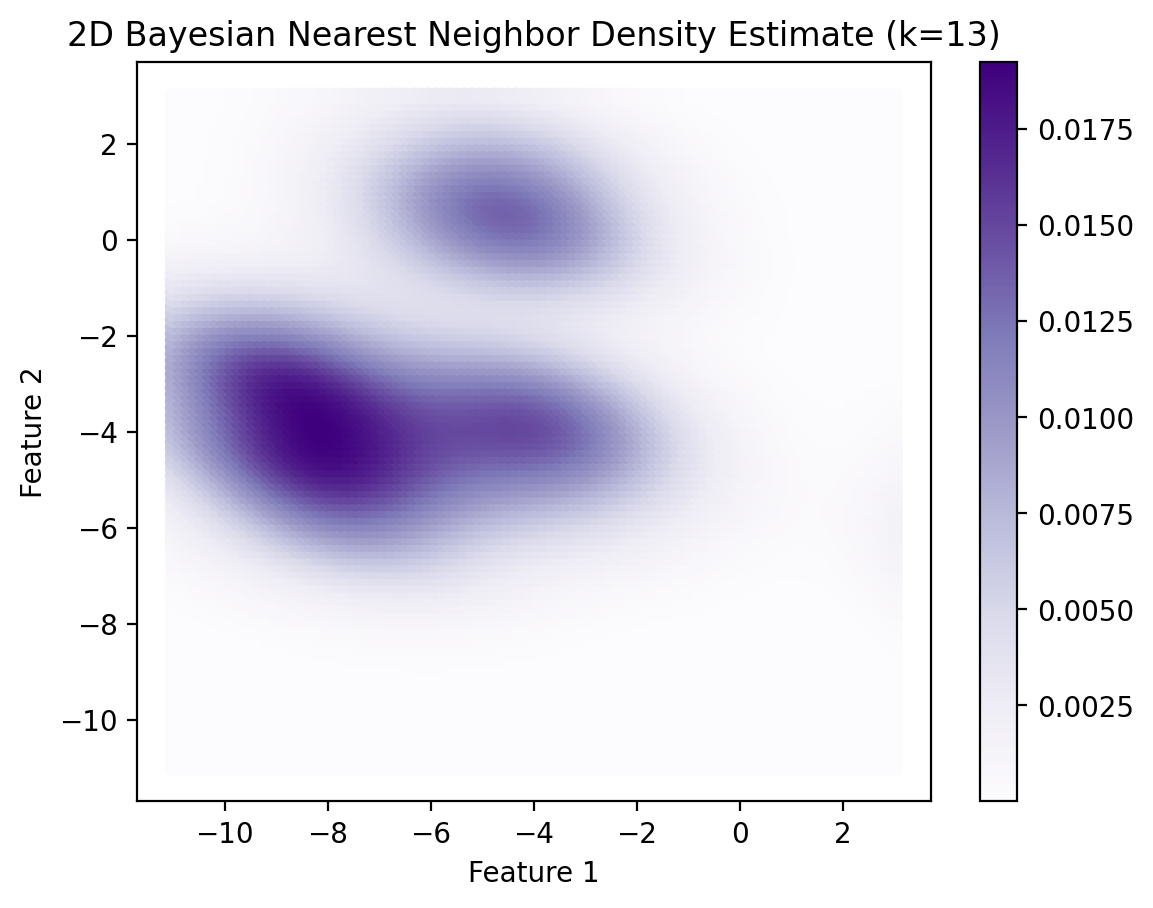

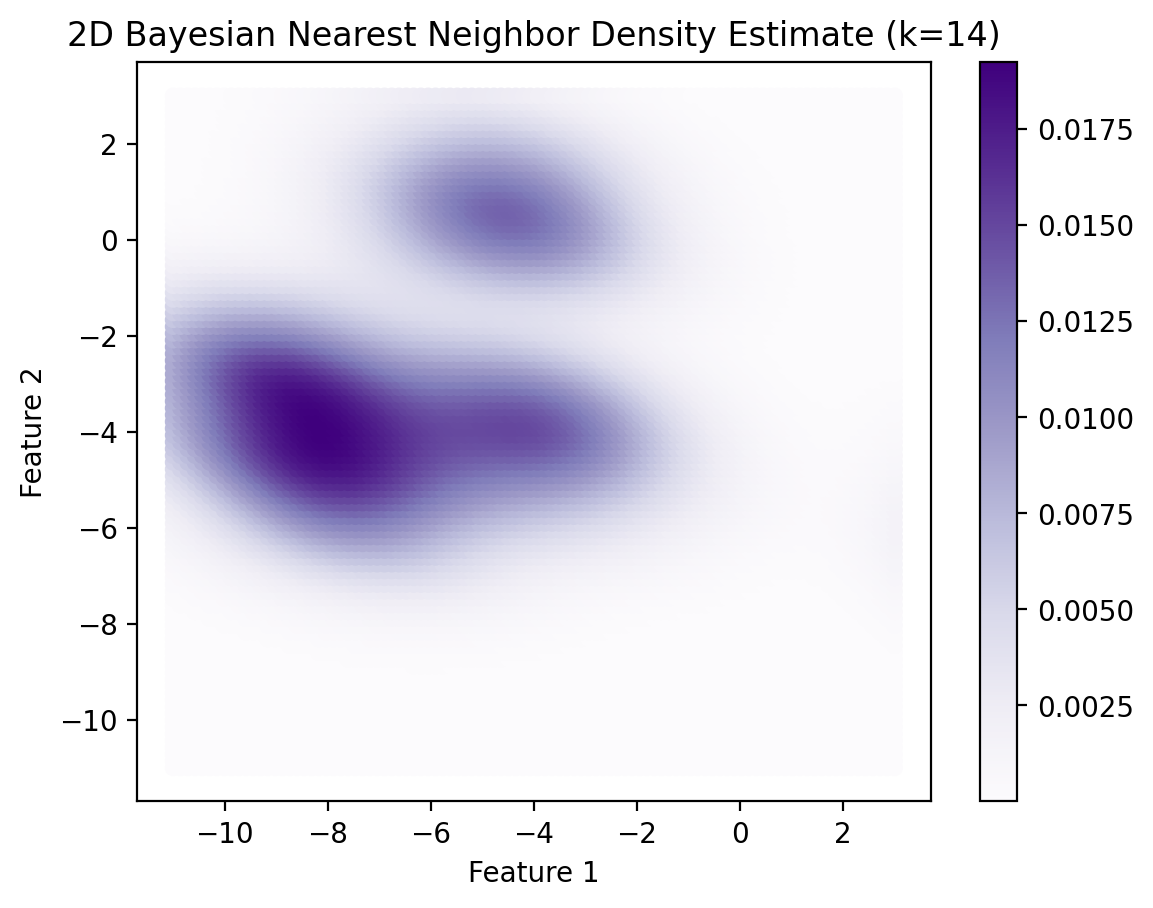

In [24]:
#Check all K's
for k in range(1, 15):  
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    radius = distances[:, -1]
    density_nbrs = k / (np.pi * radius**2 * X.shape[0])

    #KDE
    kde = gaussian_kde(X.T, bw_method=h_opt)
    dens_kde = kde(Xgrid.T)

    # Plot
    plt.figure()
    plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=dens_kde, cmap="Purples", edgecolor="None")
    plt.colorbar()
    plt.title(f'2D Bayesian Nearest Neighbor Density Estimate (k={k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


### It appears that k values 1-5 are all similar enough to the previous plot, and values larger than that start to merge 2 of the 3 highest density areas, though all k values look similar to the first KDE plot. 

SRT: You did not explore highly enough in `k`. The optimal number is somewhere between 40-100. -2 points.

## Solution 4

4.1 Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? 

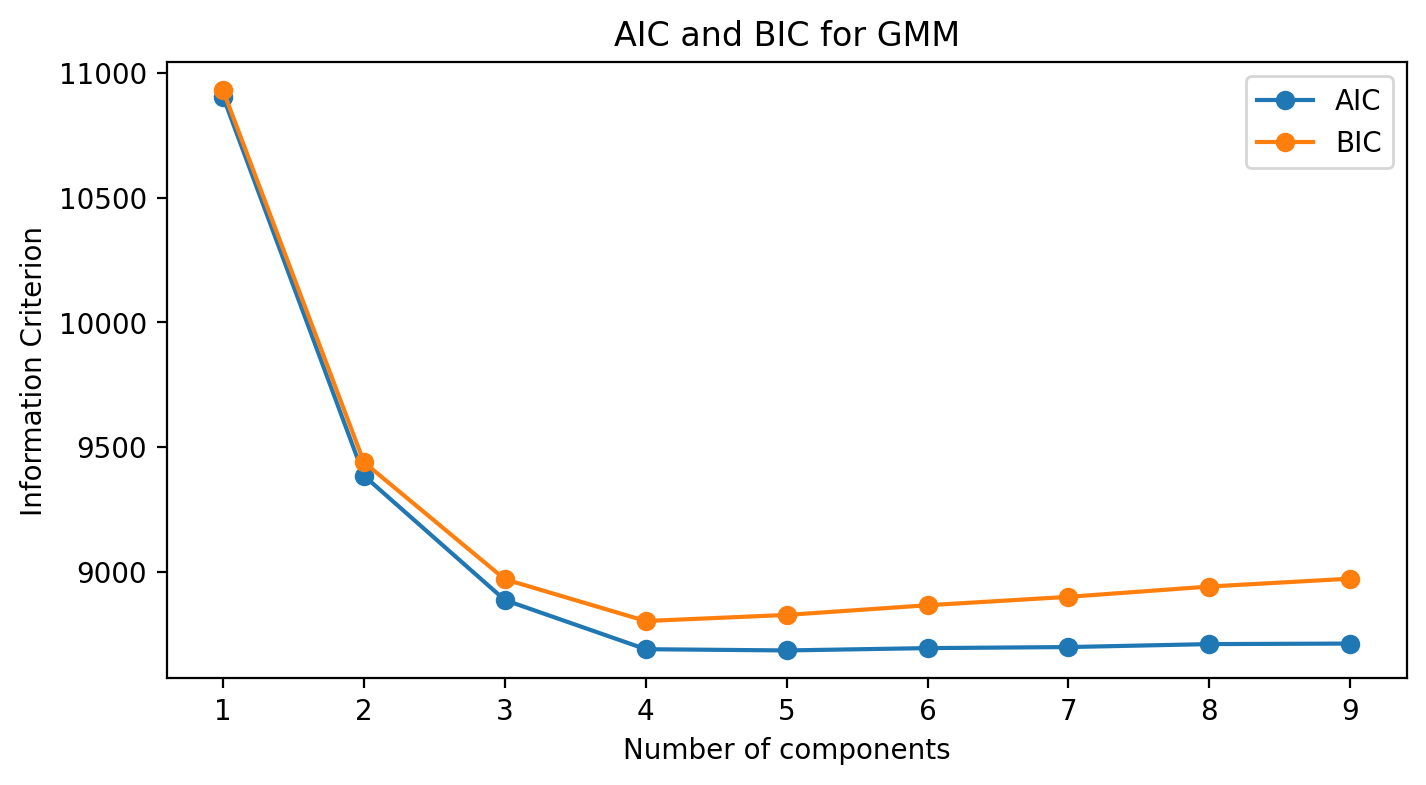

In [25]:
from sklearn.mixture import GaussianMixture

X = np.vstack([x, y]).T 
AIC = []
BIC = []

for ii in range(1, 10):
    gmm = GaussianMixture(ii)
    gmm.fit(X)
    
 
    AIC.append(gmm.aic(X))
    BIC.append(gmm.bic(X))

#Plot    
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1,10), AIC, label='AIC', marker='o')
plt.plot(np.arange(1,10), BIC, label='BIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC for GMM')
plt.show()

4.2 Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [26]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

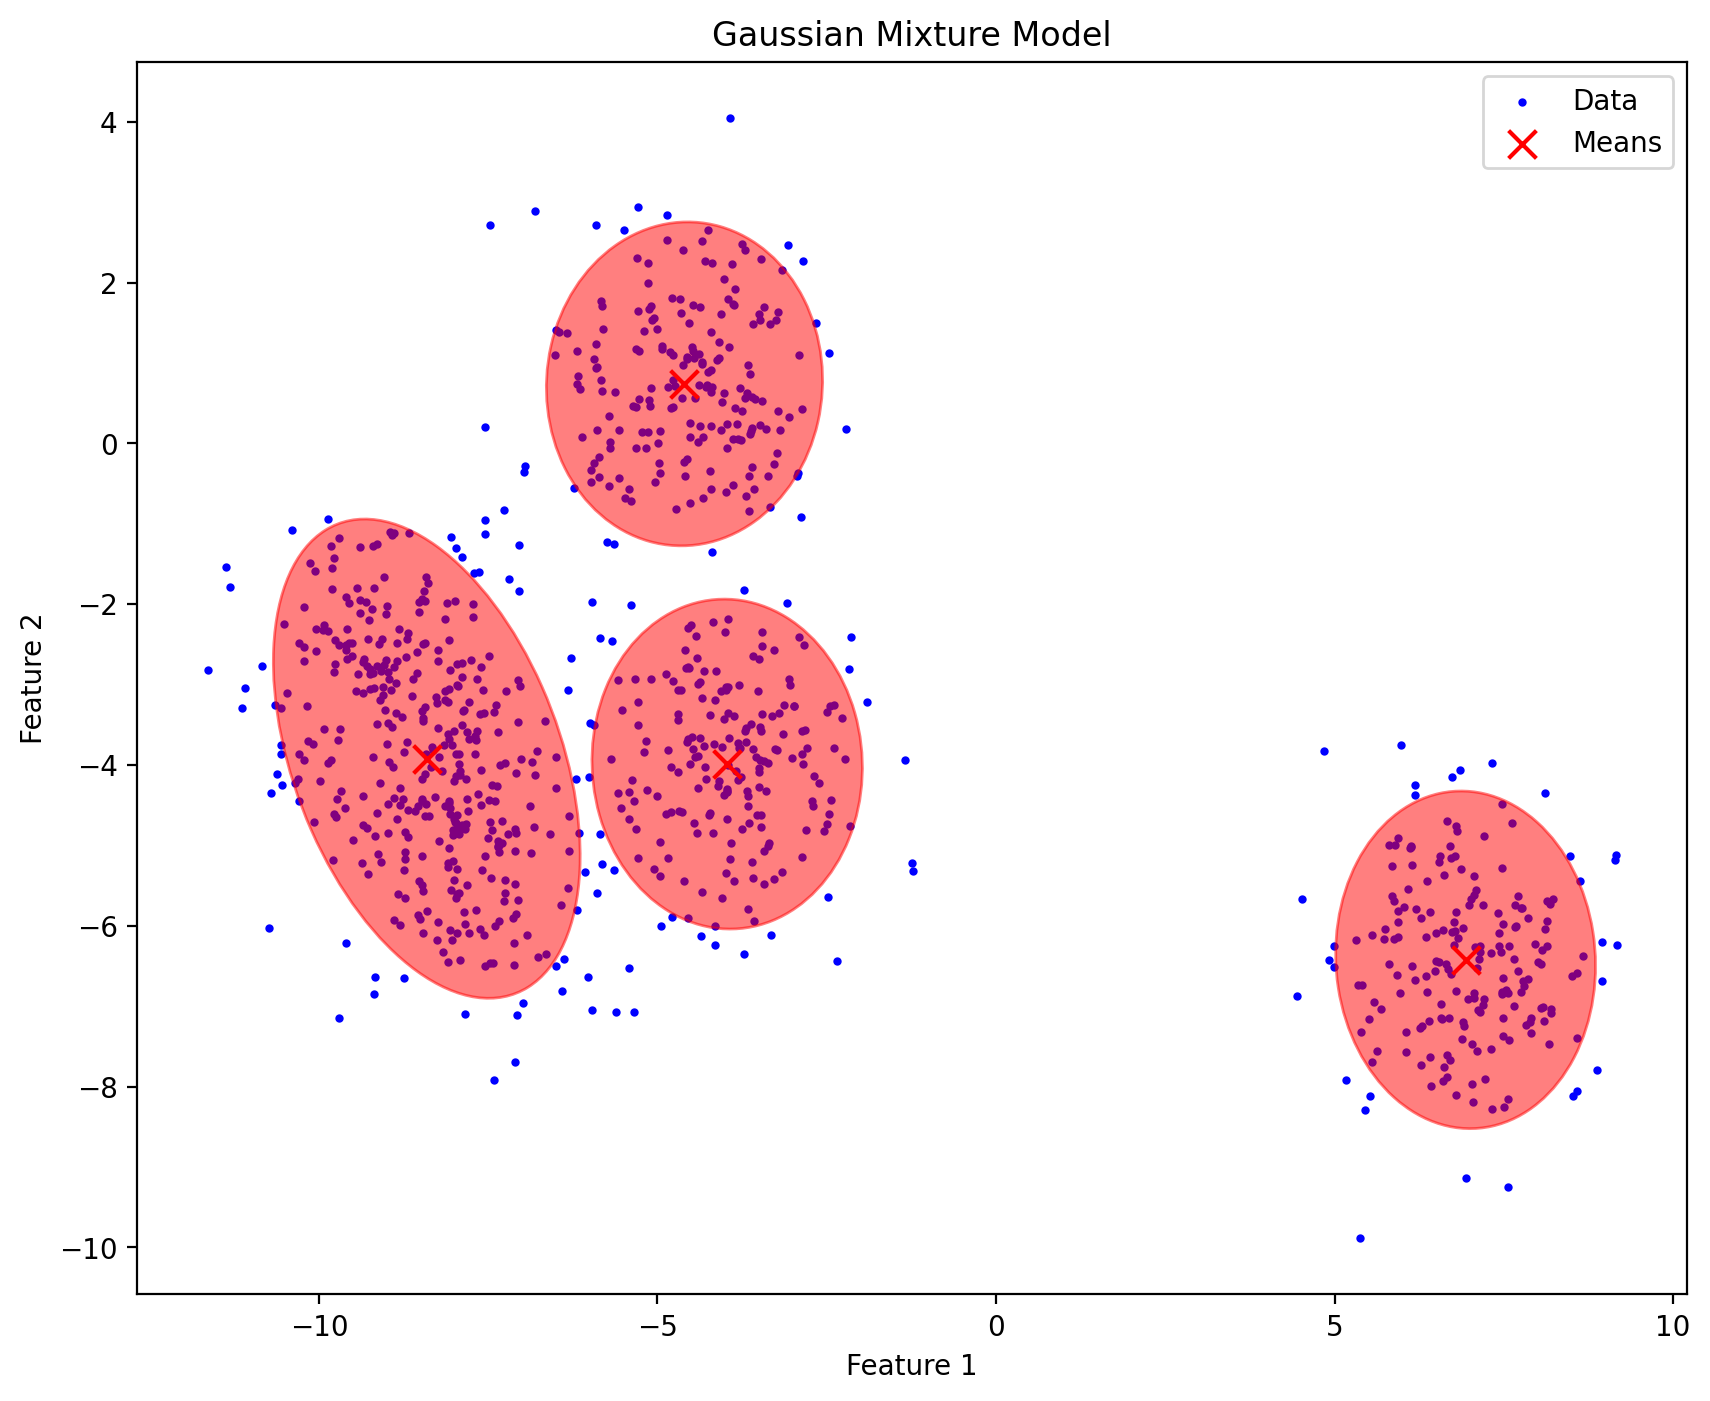

In [27]:
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(X)

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=4, label='Data', c='blue')

# Draw ellipses for the 2-sigma contours
for mean, covar in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(mean, covar, scales=[2], ax=plt.gca(), alpha=0.5, color='red')

# Plot the GMM component mean spots
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=100, marker='x', label='Means')

plt.title('Gaussian Mixture Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()  # Display the legend
plt.show()

SRT: Excellent!

## Solution 5

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### 5.1 - 5.4

/Users/jarretsm/miniforge3/envs/astr8070/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


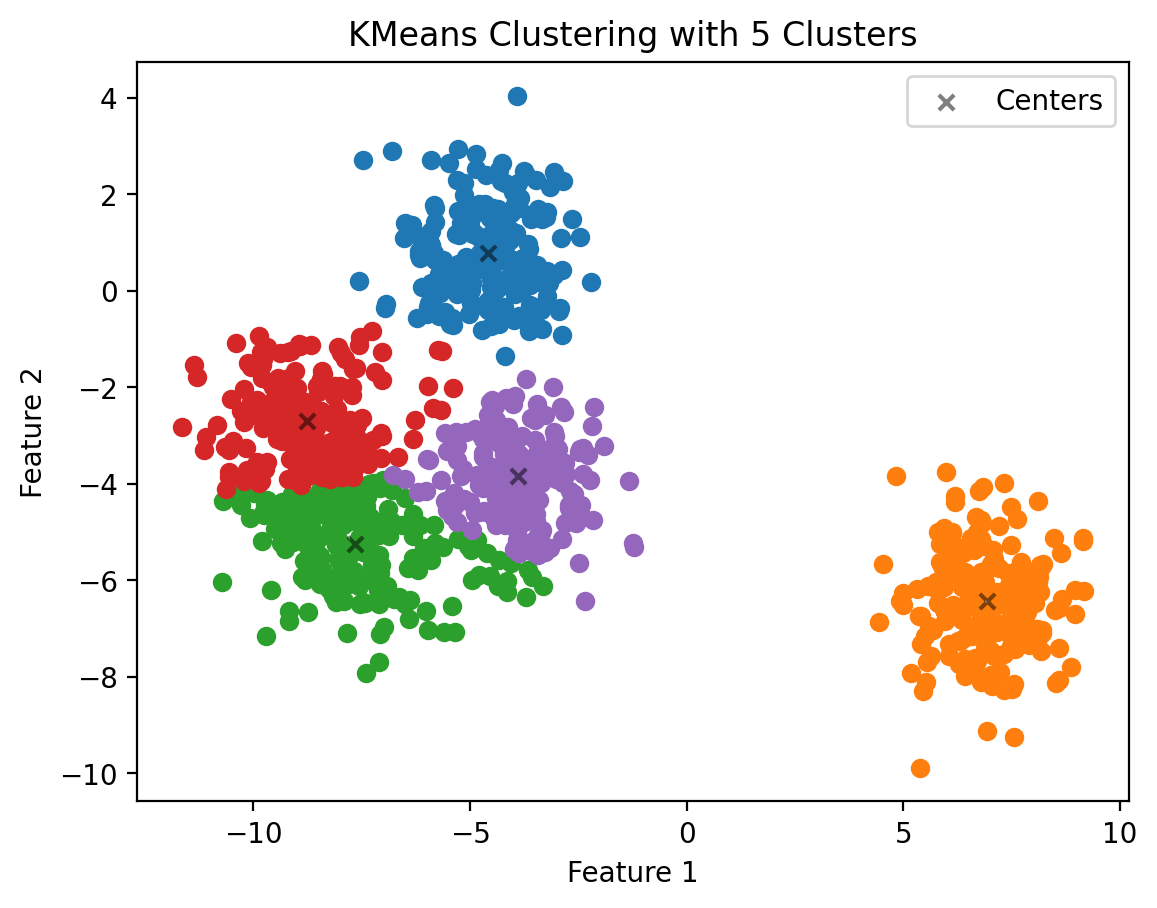

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans to scaled data
clf = KMeans(n_clusters=5)
clf.fit(X_scaled)

# Inverse transform the cluster centers 
centers_scaled = clf.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
labels = clf.predict(X_scaled)


colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for ii in range(5):
    plt.scatter(X[labels == ii, 0], X[labels == ii, 1], color=colors[ii])
    
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=30, alpha=0.5, marker='x', label='Centers')
plt.legend()
plt.title('KMeans Clustering with 5 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### 5.5

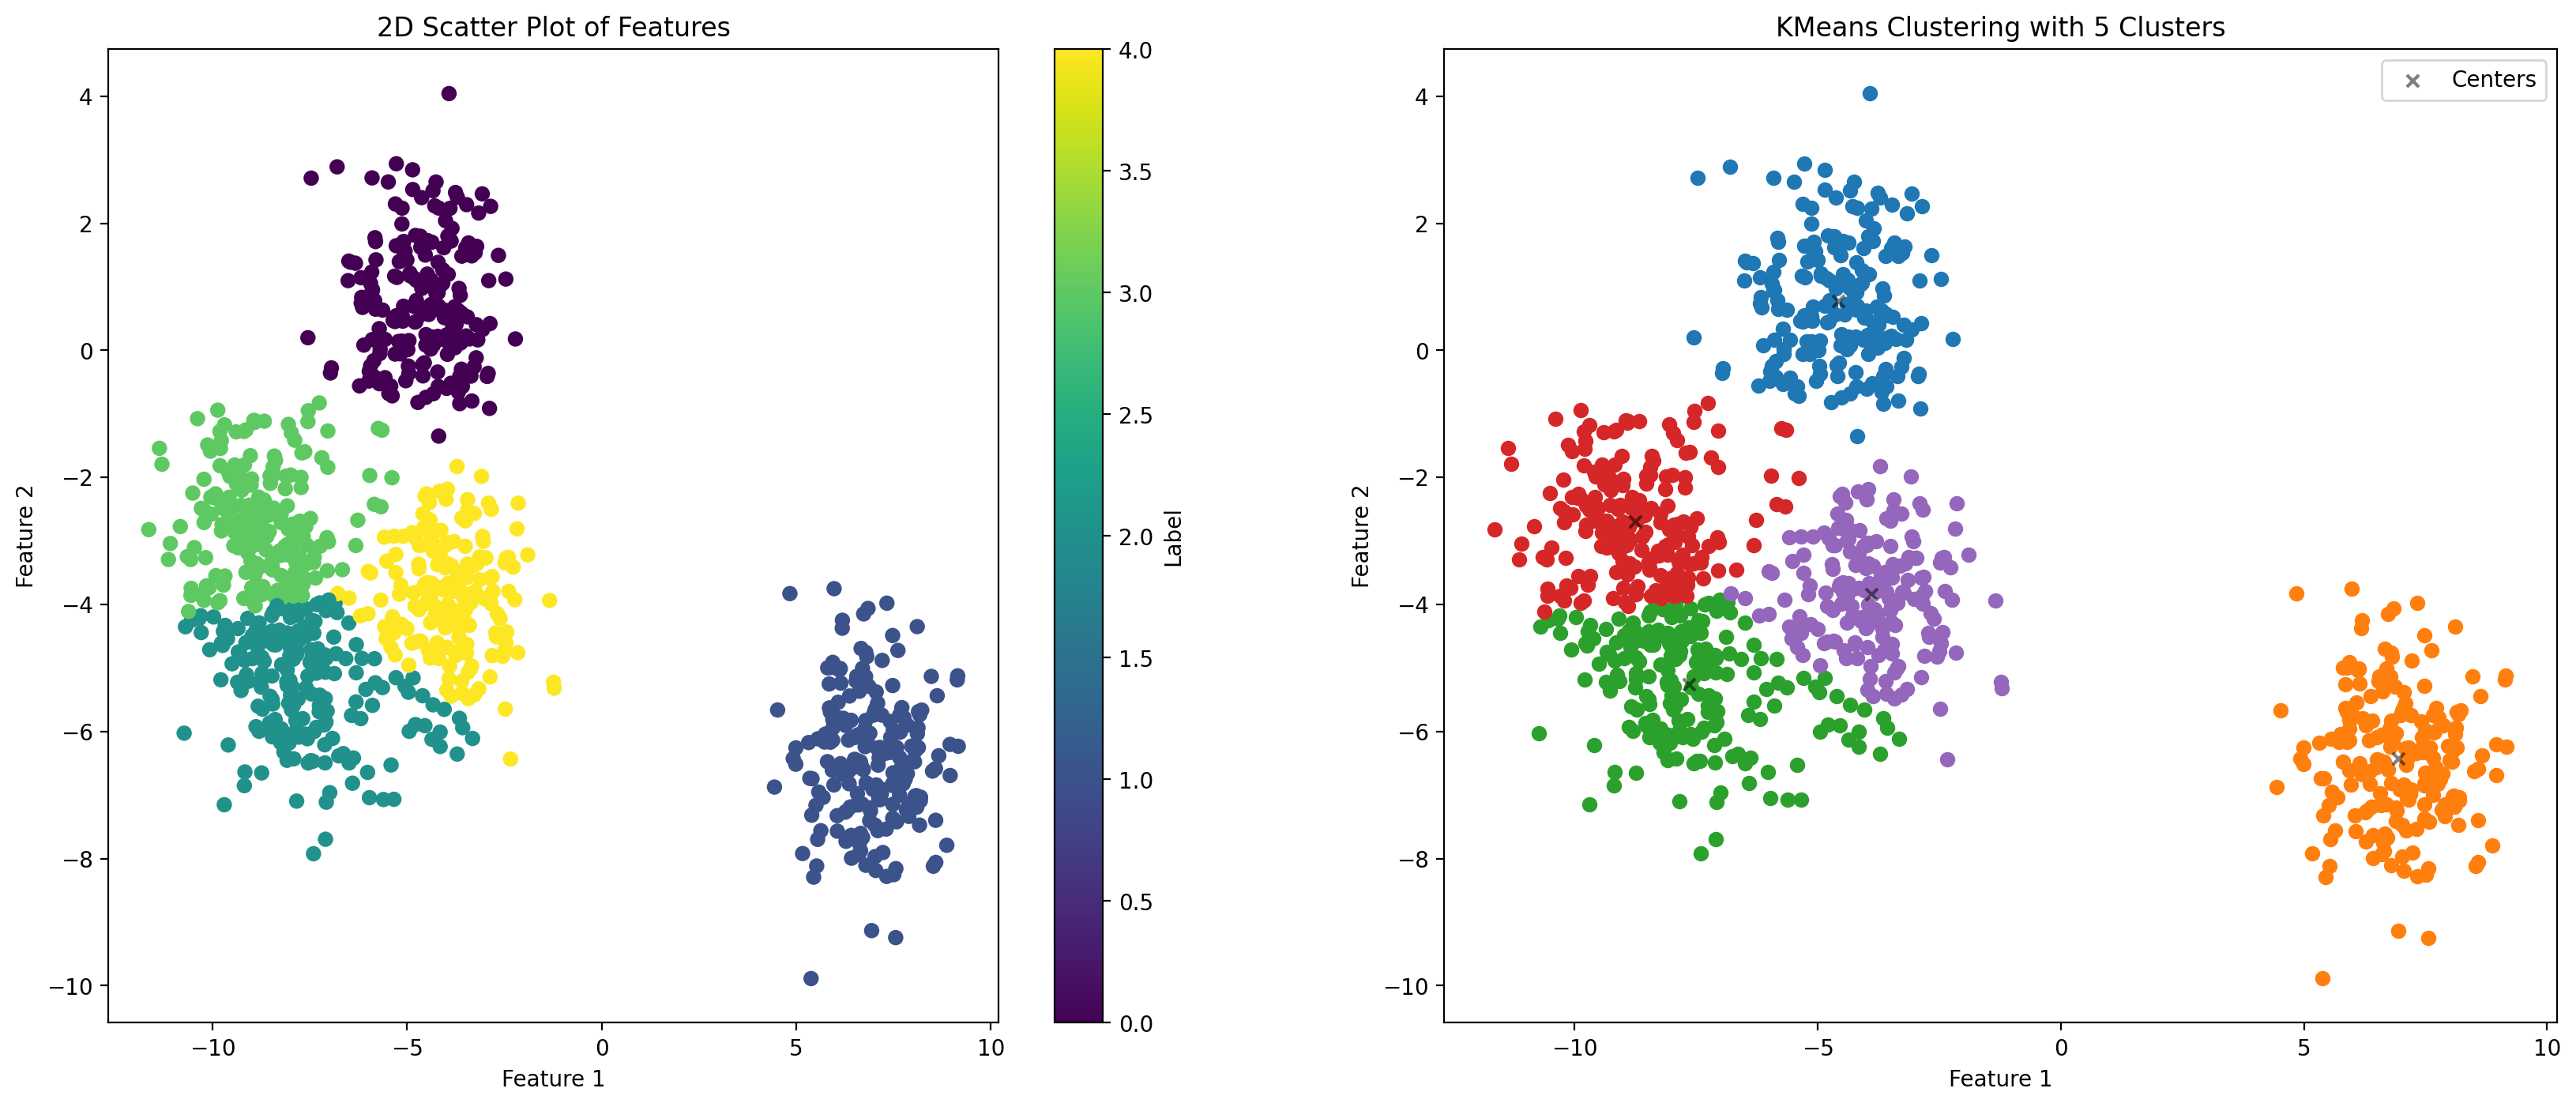

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns


scatter = axs[0].scatter(x, y, c=labels)
axs[0].set_title('2D Scatter Plot of Features')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
fig.colorbar(scatter, ax=axs[0], label='Label')



colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for ii in range(5):
    axs[1].scatter(X[labels == ii, 0], X[labels == ii, 1], color=colors[ii])
 

axs[1].scatter(centers[:, 0], centers[:, 1], c='black', s=30, alpha=0.5, marker='x', label='Centers')
axs[1].legend()
axs[1].set_title('KMeans Clustering with 5 Clusters')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')

#plt.tight_layout()
plt.show()

SRT: Awesome!